In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import combinations
import csv
from scipy.signal import resample_poly
import umap
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from pathlib import Path
import glob
import shutil
import os
import pickle


import sys
sys.path.append('/storage3/eva/code/remapping/src')
import path_formatting as pf
import motive
import oe
import utils

In [4]:
fs_pos = 120
date = "20250922"
animal = "eb03"

#help(utils.path_load)
_, ks_path, csv_path, res_path = utils.path_load(date, animal,p=True)

pa_path = Path(res_path) / "pa" 
pa_path.mkdir(parents=True, exist_ok=True)

Ola! For folders inside of res_path: Path(res_path)/"folder_name"
To make new folder (if not exist): your_path.mkdir(parents=True, exist_ok=True)


In [5]:
# 22sep
pyr = [613,623,637,641,647,651,659,671,683,687,709,715,717,731,734,738,742,752,
       815,852,864,886,900,910,913,914]
pyr_n = [645,667,681,798,815,819,862,858,860,866,894,912]
inter = [595,597,601,607,609,615,619,621,633,663,707,768,782]
noise = [681,719,721,744,750,754,758,760,882,901]

In [11]:
uoi = list(goodspiketimes.keys())

In [6]:
goodspiketimes = oe.ks_load(ks_path)
res_path_path = Path(res_path)
with open(Path(res_path) / f"preprocessing/behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)

Sup! U have...
59 phy-good clusters


In [12]:
csv_dict = motive.get_csv_dict(csv_path)
with open(Path(f'{res_path}/preprocessing') / f"meta_{date}.pkl", "rb") as f:
    meta = pickle.load(f)
meta

{'of1': '20250922_4', 'of2': '20250922_1', 'of3': '20250922_6'}

In [ ]:
# of_keys_awake = list(periods.keys())[1::2] # ['of1', 'of2', 'of3']
# motive_keys_awake = [f'{date}_2',f'{date}_4',f'{date}_6']
# meta_awake = dict(zip(of_keys_awake, motive_keys_awake))
# meta_awake

{'of1': '20250718_2', 'of2': '20250718_4', 'of3': '20250718_6'}

In [13]:
periods

{'sl1': [np.int64(147505), np.int64(61968710)],
 'of1': [np.int64(62199545), np.int64(107577393)],
 'sl2': [np.int64(107815611), np.int64(149472898)],
 'of2': [np.int64(149473149), np.int64(194521248)],
 'sl3': [np.int64(194888003), np.int64(274262965)],
 'of3': [np.int64(274263216), np.int64(319559643)],
 'sl4': [np.int64(319827493), np.int64(375655827)]}

In [14]:
spikes_by_periods = {}

for of in periods.keys():
    start, end = periods[of]

    spikes_by_periods[of] = {}
    for unit in goodspiketimes.keys():
        spikes = goodspiketimes[unit]
        spikes_in_trial = spikes[(spikes >= start) & (spikes <= end)] - start
        spikes_by_periods[of][unit] = spikes_in_trial

In [10]:
with open(Path(res_path) / f"unit_classes_{date}.pkl", "rb") as f:
    unit_class_dict = pickle.load(f)

uoi = list(goodspiketimes.keys())
pyr = [u for u in uoi if unit_class_dict[u] == "pyr"]
inter = [u for u in uoi if unit_class_dict[u] == "int"]

FileNotFoundError: [Errno 2] No such file or directory: '/storage3/eva/code/neuropixels/results/eb03/eb03_20250922/unit_classes_20250922.pkl'

In [ ]:
# THIS ONE RUN ONLY FIRST TIME

# # sliding 300ms window with 100ms step

# def accumarray(spike_times_dict, sampling_rate=30000, bin_size_ms=300, step_size_ms=100):
#     bin_size = int(bin_size_ms / 1000 * sampling_rate)
#     step_size = int(step_size_ms / 1000 * sampling_rate)

#     # Get all spike times to determine bin range
#     max_time = max([np.max(spikes) if len(spikes) > 0 else 0 for spikes in spike_times_dict.values()])
#     bin_starts = np.arange(0, max_time - bin_size + 1, step_size)
#     n_bins = len(bin_starts)
#     cell_ids = sorted(spike_times_dict.keys())
#     n_cells = len(cell_ids)

#     # Initialize output matrix: (n_cells, n_bins)
#     spike_matrix = np.zeros((n_cells, n_bins), dtype=int)

#     for i, cell_id in enumerate(cell_ids):
#         spikes = np.array(spike_times_dict[cell_id])
#         for j, start in enumerate(bin_starts):
#             end = start + bin_size
#             spike_matrix[i, j] = np.sum((spikes >= start) & (spikes < end))

#     # Bin centers in seconds
#     bin_centers_sec = (bin_starts + bin_size // 2) / sampling_rate
#     return spike_matrix, bin_centers_sec, cell_ids

# spike_matrix = {}
# bin_centers_sec = {}
# cell_ids = {}

# for of in periods.keys():
#     spike_matrix[of], bin_centers_sec[of], cell_ids[of] = accumarray(spikes_by_periods[of])

# accumarray4umap = {}
# accumarray4umap['spike_matrix'] = spike_matrix
# accumarray4umap['bin_centers_sec'] = bin_centers_sec
# accumarray4umap['cell_ids'] = cell_ids

# with open(f"{pa_path}/accumarray4umap_extended_{date}.pkl", "wb") as f:
#     pickle.dump(accumarray4umap, f)

In [15]:
with open(f'{pa_path}/accumarray4umap_extended_{date}.pkl', "rb") as f:
    accumarray4umap = pickle.load(f)


spike_matrix = accumarray4umap['spike_matrix']
bin_centers_sec = accumarray4umap['bin_centers_sec']
cell_ids = accumarray4umap['cell_ids']

In [16]:
pos_data_interp = {}
frame_times_all = {}

# for i, trial in enumerate(motive_keys_awake):
#     df = csv_dict[trial]
#     frame_times_all[of_keys_awake[i]] = motive.get_frame_times(df)
#     _, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array = ['X','Y','Z'], interpolate=True)
#     pos_data_interp[of_keys_awake[i]]=arrays_interpol

for k in meta.keys():
    df = csv_dict[meta[k]]
    frame_times_all[k] = motive.get_frame_times(df)
    _, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array = ['X','Y','Z'], interpolate=True)
    pos_data_interp[k]=arrays_interpol

with open(Path(res_path) / "preprocessing" / f"smooth_pitch_dict_{date}.pkl", "rb") as f:
    smooth_pitch_dict = pickle.load(f)
smooth_pitch_dict

{'sigma': 3,
 'of1': array([-44.29601696, -44.1299626 , -43.81168235, ...,  56.88147499,
         57.38630856,  57.66271865], shape=(181512,)),
 'of2': array([ -6.30112832,  -6.32028458,  -6.36090926, ..., -36.42524358,
        -36.43815322, -36.45213117], shape=(180193,)),
 'of3': array([54.12514684, 54.3006722 , 54.56962971, ..., 50.78501435,
        51.20551671, 51.43043394], shape=(181186,))}

In [10]:
pos_data_interp

{'of1': {'X': array([0.204728, 0.204768, 0.204789, ..., 0.279817, 0.280309, 0.280714],
        shape=(180488,)),
  'Y': array([0.07442 , 0.074456, 0.074393, ..., 0.221525, 0.221775, 0.222329],
        shape=(180488,)),
  'Z': array([0.237985, 0.237957, 0.237885, ..., 0.492871, 0.493073, 0.493743],
        shape=(180488,))},
 'of2': {'X': array([ 0.252493,  0.252508,  0.252543, ..., -0.116269, -0.118097,
         -0.119628], shape=(180972,)),
  'Y': array([0.17669 , 0.176653, 0.17661 , ..., 0.0805  , 0.078791, 0.077463],
        shape=(180972,)),
  'Z': array([ 0.364574,  0.364477,  0.364396, ..., -0.409995, -0.411513,
         -0.412684], shape=(180972,))},
 'of3': {'X': array([0.28637 , 0.286409, 0.286449, ..., 0.169808, 0.170167, 0.170754],
        shape=(180623,)),
  'Y': array([0.20252 , 0.20263 , 0.202687, ..., 0.094098, 0.093864, 0.092806],
        shape=(180623,)),
  'Z': array([ 0.328572,  0.328429,  0.328273, ..., -0.491289, -0.490729,
         -0.49005 ], shape=(180623,))}}

In [17]:
pos_data_resampled = {}
pitch_resampled = {}
speeds = {} # already resampled to firing bins

for of in meta.keys():

    # position
    print(of)
    pitch_resampled[of] = np.interp(
                bin_centers_sec[of], 
                np.arange(len(smooth_pitch_dict[of]))/fs_pos, 
                smooth_pitch_dict[of]
                )*(-1) # here I flip pitch
    print(pitch_resampled[of].shape)
    
    pd_res = {}
    for dim in pos_data_interp[of].keys():
        pd_res[dim] = np.interp(
            bin_centers_sec[of], 
            np.arange(len(pos_data_interp[of][dim]))/fs_pos, 
            pos_data_interp[of][dim]
            )
        print(pd_res[dim].shape)
    pos_data_resampled[of] = pd_res

    # speed
    _, _, speed = motive.speed(
    pos_data_interp[of]['X'], 
    pos_data_interp[of]['Z'], 
    frame_times_all[of])
    
    print(f'{of}: original {speed.shape}')
    
    # resampling of speed bins to match neural bins
    speeds[of] = np.interp(bin_centers_sec[of], np.arange(len(speed)) / fs_pos, speed)
    print(f'{of}: resampled {speeds[of].shape} \n')

of1
(15123,)
(15123,)
(15123,)
(15123,)
of1: original (181512,)
of1: resampled (15123,) 

of2
(15013,)
(15013,)
(15013,)
(15013,)
of2: original (180193,)
of2: resampled (15013,) 

of3
(15096,)
(15096,)
(15096,)
(15096,)
of3: original (181186,)
of3: resampled (15096,) 



In [12]:
pos_data_resampled, pitch_resampled

({'of1': {'X': array([0.204554, 0.204524, 0.20405 , ..., 0.275633, 0.278582, 0.278434],
         shape=(15038,)),
   'Y': array([0.074654, 0.074346, 0.075297, ..., 0.223052, 0.222017, 0.221301],
         shape=(15038,)),
   'Z': array([0.237763, 0.237839, 0.237689, ..., 0.499082, 0.499771, 0.495776],
         shape=(15038,))},
  'of2': {'X': array([ 0.253966,  0.25337 ,  0.251572, ..., -0.020348, -0.024685,
          -0.052426], shape=(15078,)),
   'Y': array([0.175299, 0.17435 , 0.172143, ..., 0.124897, 0.125317, 0.113933],
         shape=(15078,)),
   'Z': array([ 0.363114,  0.363284,  0.365083, ..., -0.368385, -0.369629,
          -0.396392], shape=(15078,))},
  'of3': {'X': array([0.286133, 0.28608 , 0.286348, ..., 0.172207, 0.172032, 0.17143 ],
         shape=(15049,)),
   'Y': array([0.202752, 0.202645, 0.202598, ..., 0.094466, 0.094431, 0.094651],
         shape=(15049,)),
   'Z': array([ 0.327626,  0.327471,  0.327316, ..., -0.49226 , -0.492271,
          -0.492708], shape=(150

In [18]:
# Filter by speed
spike_matrix_run = {}
pos_data_run = {}
pitch_run = {}
speeds_run = {}

y_thresh = 0.15
speed_cutoff = 0.02

for of in meta.keys():
    # mask = speeds[of] > 0.02  # 2 cm/s 
    mask = (pos_data_resampled[of]['Y'] >= y_thresh) | (speeds[of] > speed_cutoff) # double mask

    spike_matrix_run[of] = spike_matrix[of][:, mask].T  # (n_valid_bins, n_cells)
    print(spike_matrix_run[of].shape)

    pitch_run[of]= pitch_resampled[of][mask].T
    print(pitch_run[of].shape)

    speeds_run[of] = speeds[of][mask]
    print(speeds_run[of].shape)

    # in case u wanna normalise
    # X = StandardScaler().fit_transform(X)
    pd = {}
    for dim in pos_data_resampled[of].keys():
        pd[dim] = pos_data_resampled[of][dim][mask]
        print(pd[dim].shape)
    pos_data_run[of] = pd
    print()

(14440, 59)
(14440,)
(14440,)
(14440,)
(14440,)
(14440,)

(14440, 59)
(14440,)
(14440,)
(14440,)
(14440,)
(14440,)

(15046, 59)
(15046,)
(15046,)
(15046,)
(15046,)
(15046,)



## UMAP

- of_keys_awake --> of only
- of_keys --> + sleep

In [19]:
of_all = np.concatenate([spike_matrix_run['of1'], spike_matrix_run['of2'], spike_matrix_run['of3']], axis=0)
of_all.shape

(43926, 59)

In [20]:
split_of1 = spike_matrix_run['of1'].shape[0]
split_of2 = spike_matrix_run['of2'].shape[0]
split_of3 = spike_matrix_run['of3'].shape[0]

In [21]:
np.array(list(goodspiketimes.keys())).shape

(59,)

In [17]:
list(pyr)

[31,
 61,
 105,
 123,
 134,
 155,
 166,
 173,
 180,
 195,
 263,
 266,
 276,
 288,
 308,
 312,
 317,
 332,
 339,
 357,
 494,
 498,
 507,
 529,
 553,
 576,
 589,
 593,
 603,
 632,
 753,
 795,
 803,
 807,
 881,
 883,
 887,
 899,
 915,
 925,
 927]

In [22]:
umap_kwargs = dict(n_neighbors=20, min_dist=0.5, metric='euclidean', random_state=42)

# split onto pyr and inter
cell_ids_all  = np.array(list(goodspiketimes.keys()))
mask_pyr = np.isin(cell_ids_all, list(pyr))
mask_inter = np.isin(cell_ids_all, list(inter))
X_all = of_all
X_pyr = X_all[:, mask_pyr]
X_inter = X_all[:, mask_inter]

pyr_reducer = umap.UMAP(**umap_kwargs)
pyr_emb = pyr_reducer.fit_transform(X_pyr)

inter_reducer = umap.UMAP(**umap_kwargs)
inter_emb = inter_reducer.fit_transform(X_inter)

/storage3/eva/apps/anaconda3/envs/nma/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/storage3/eva/apps/anaconda3/envs/nma/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [23]:
from matplotlib.colors import ListedColormap, BoundaryNorm

BORDERS = [-90,-30, 90]
LABELS  = ['low', 'high']
CMAP    = ListedColormap(['#48a0b2', '#fdae61'])  #(['#7B951D', '#FC600A'])
NORM    = BoundaryNorm(BORDERS, CMAP.N, clip=True)

def plot_umap(emb, celltype, of, date, pos_dict, pitch_deg):

    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    
    sc1 = axs[0].scatter(emb[:,0], emb[:,1], c=pos_dict['X'], cmap='viridis', s=6)
    fig.colorbar(sc1, ax=axs[0], label='X (m)', shrink=0.7, aspect=12)
    axs[0].set_title('UMAP colored by X'); axs[0].set_xlabel('UMAP 1'); axs[0].set_ylabel('UMAP 2')

    sc2 = axs[1].scatter(emb[:,0], emb[:,1], c=pos_dict['Z'], cmap='viridis', s=6)
    fig.colorbar(sc2, ax=axs[1], label='Z (m)', shrink=0.7, aspect=12)
    axs[1].set_title('UMAP colored by Z'); axs[1].set_xlabel('UMAP 1'); axs[1].set_ylabel('UMAP 2')

    # Pitch in degrees + discrete bins via BoundaryNorm
    pitch = np.asarray(pitch_deg, float)
    valid = np.isfinite(pitch)
    sc3 = axs[2].scatter(emb[valid,0], emb[valid,1], c=pitch[valid], cmap=CMAP, norm=NORM, s=6)
    axs[2].set_title('UMAP colored by pitch'); axs[2].set_xlabel('UMAP 1'); axs[2].set_ylabel('UMAP 2')

    # Discrete ticks at bin midpoints
    tick_pos = [(-90 + -30)/2, (-30 + 90)/2]  # midpoints
    cbar3 = fig.colorbar(sc3, ax=axs[2], ticks=tick_pos, shrink=0.7, aspect=12)
    cbar3.ax.set_yticklabels(LABELS); cbar3.set_label('Pitch (°)')

    filename = f'UMAP_{celltype}_speedFiltered_{of}_{date}'
    fig.suptitle(filename, fontsize=12)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(pa_path / f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()

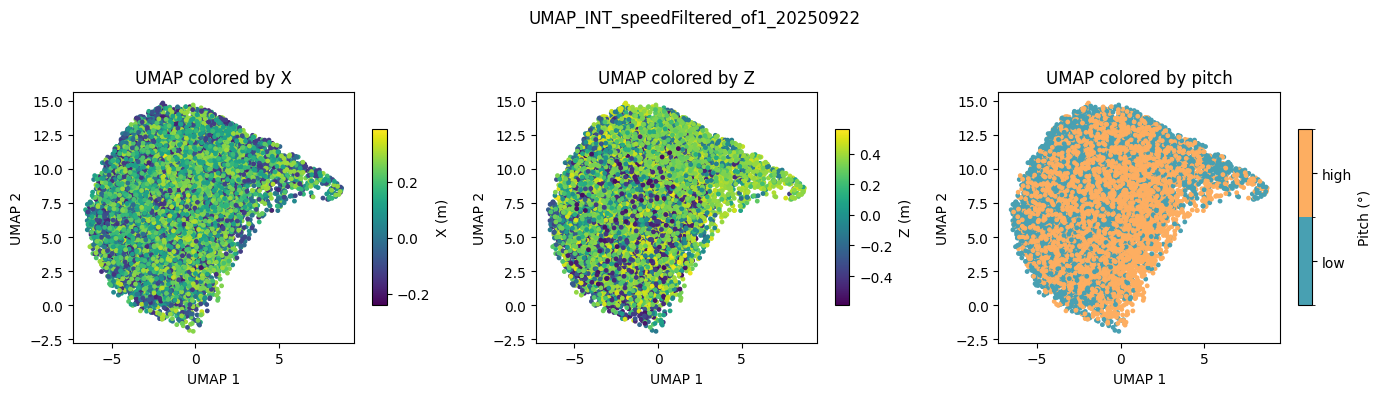

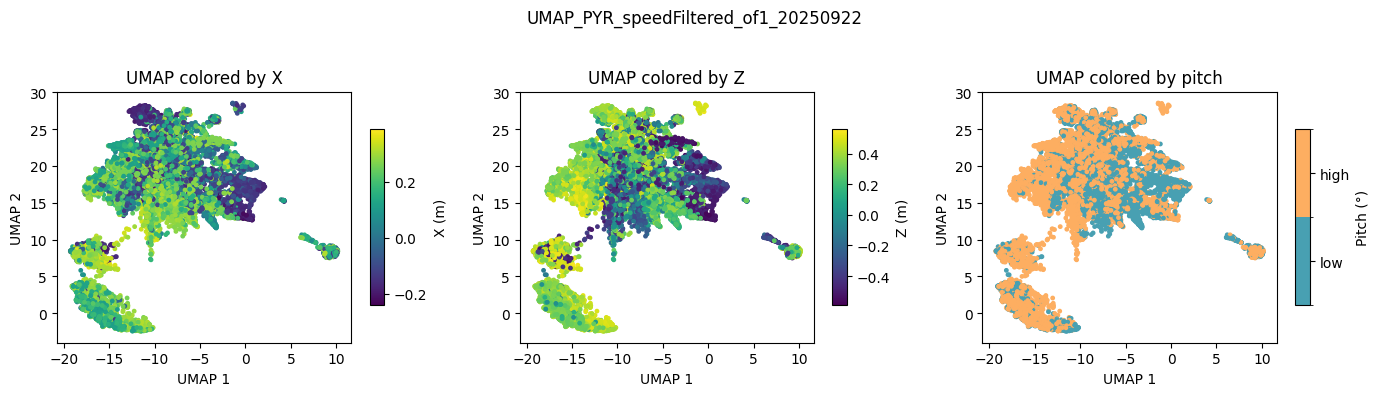

In [24]:
of = 'of1'
plot_umap(inter_emb[:split_of1], 'INT', of=of, date=date, pos_dict=pos_data_run[of], pitch_deg=pitch_run[of])
plot_umap(pyr_emb[:split_of1], 'PYR', of=of, date=date, pos_dict=pos_data_run[of], pitch_deg=pitch_run[of])

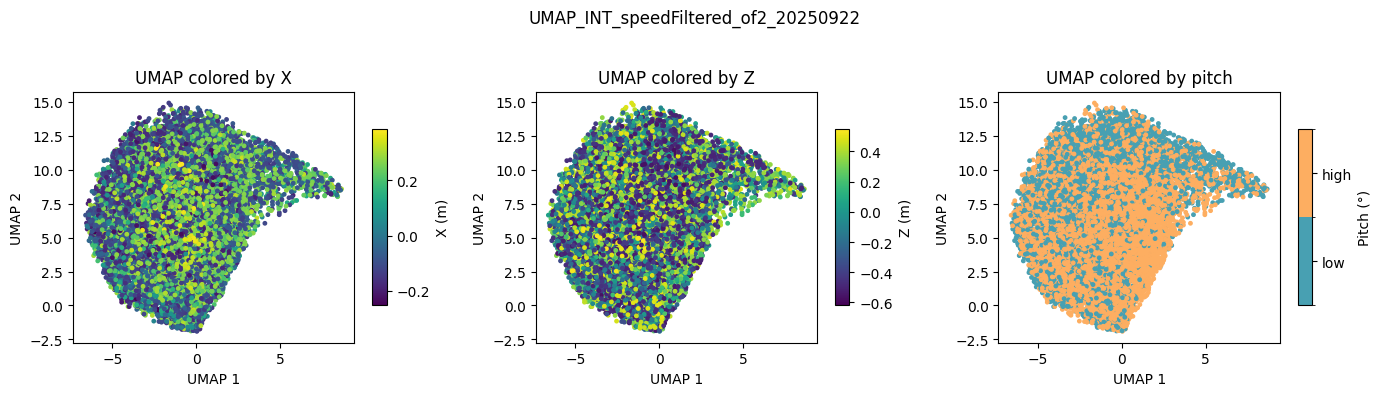

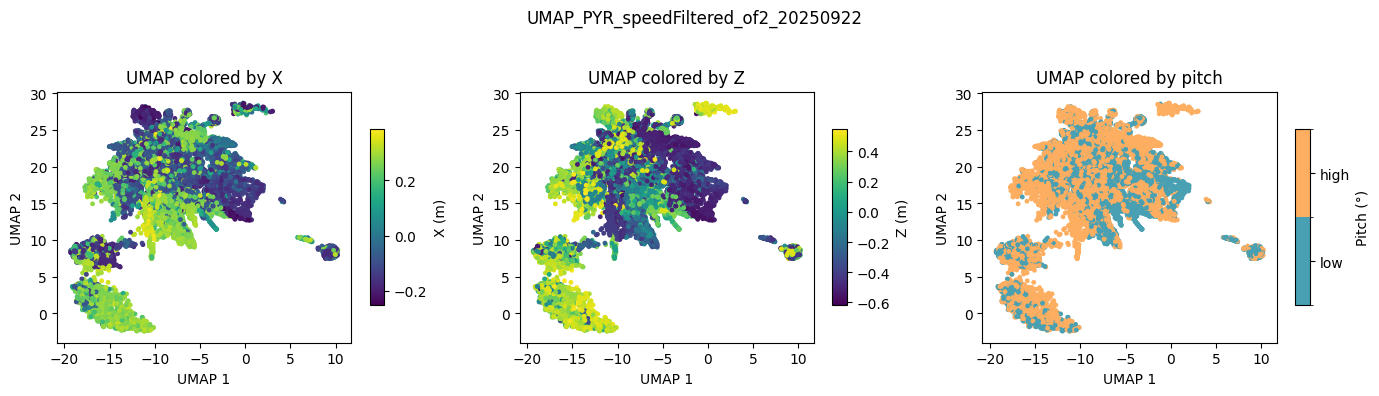

In [25]:
of = 'of2'
plot_umap(inter_emb[split_of1:split_of1+split_of2], 'INT', of=of, date=date, pos_dict=pos_data_run[of], pitch_deg=pitch_run[of])
plot_umap(pyr_emb[split_of1:split_of1+split_of2], 'PYR', of=of, date=date, pos_dict=pos_data_run[of], pitch_deg=pitch_run[of])

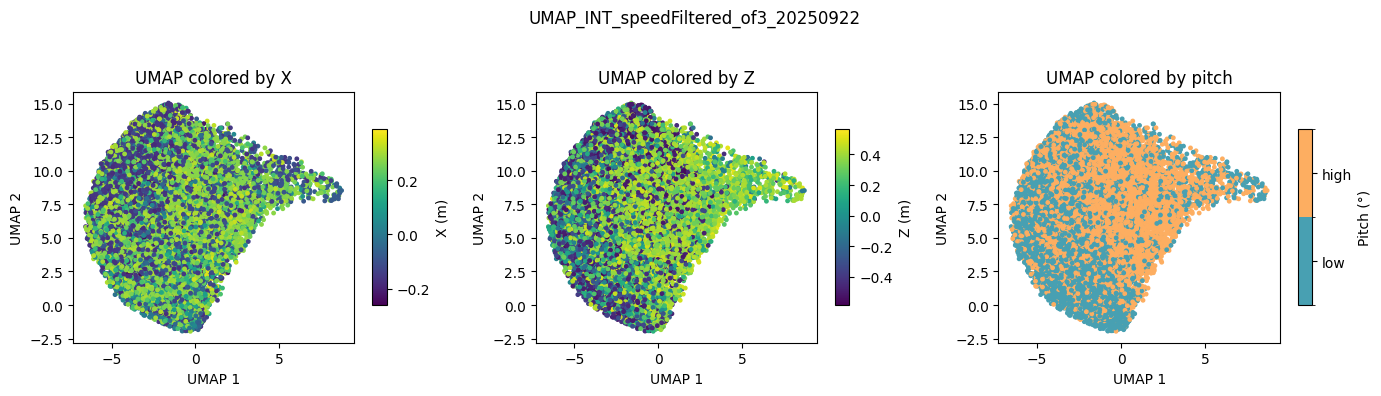

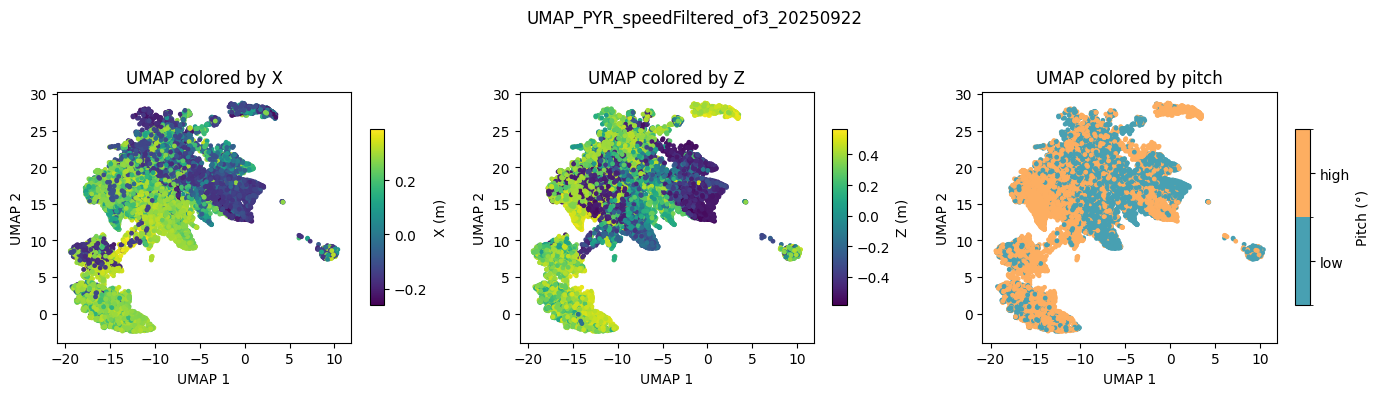

In [26]:
of = 'of3'
plot_umap(inter_emb[split_of1+split_of2:], 'INT', of=of, date=date, pos_dict=pos_data_run[of], pitch_deg=pitch_run[of])
plot_umap(pyr_emb[split_of1+split_of2:], 'PYR', of=of, date=date, pos_dict=pos_data_run[of], pitch_deg=pitch_run[of])

lets check sleep

In [27]:
spike_matrix['sl1'].shape

(59, 20605)

In [28]:
X_all_wsleep = np.concatenate([
    spike_matrix['sl1'].T,
    spike_matrix['of1'].T,
    spike_matrix['sl2'].T, 
    spike_matrix['of2'].T,
    spike_matrix['sl3'].T, 
    spike_matrix['of3'].T,
    spike_matrix['sl4'].T], 
    axis=0)

st_of1 = spike_matrix['of1'].T.shape[0]
st_of2 = spike_matrix['of2'].T.shape[0]
st_of3 = spike_matrix['of3'].T.shape[0]

st_sl1 = spike_matrix['sl1'].T.shape[0]
st_sl2 = spike_matrix['sl2'].T.shape[0]
st_sl3 = spike_matrix['sl3'].T.shape[0]
st_sl4 = spike_matrix['sl4'].T.shape[0]

In [29]:
# Each original matrix
blocks = [
    spike_matrix['sl1'].T,
    spike_matrix['of1'].T,
    spike_matrix['sl2'].T,
    spike_matrix['of2'].T,
    spike_matrix['sl3'].T,
    spike_matrix['of3'].T,
    spike_matrix['sl4'].T,
]

# Concatenate
X_all_wsleep = np.concatenate(blocks, axis=0)

# Save lengths of each block (number of rows after transpose)
lengths = [b.shape[0] for b in blocks]

# Compute cumulative split points
split_points = np.cumsum(lengths)[:-1]

In [30]:
X_pyr_wsleep = X_all_wsleep[:, mask_pyr]
X_inter_wsleep = X_all_wsleep[:, mask_inter]

In [31]:
pyr_reducer_wsleep = umap.UMAP(**umap_kwargs)
pyr_emb_wsleep = pyr_reducer_wsleep.fit_transform(X_pyr_wsleep)

inter_reducer_wsleep = umap.UMAP(**umap_kwargs)
inter_emb_wsleep = inter_reducer_wsleep.fit_transform(X_inter_wsleep)

/storage3/eva/apps/anaconda3/envs/nma/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/storage3/eva/apps/anaconda3/envs/nma/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [32]:
# Split back into original blocks
recovered_blocks_inter = np.split(inter_emb_wsleep, split_points, axis=0)
recovered_blocks_pyr = np.split(pyr_emb_wsleep, split_points, axis=0)

names = list(spike_matrix.keys())
emb_pyr_dict = {name: arr for name, arr in zip(names, recovered_blocks_pyr)}
emb_inter_dict = {name: arr for name, arr in zip(names, recovered_blocks_inter)}

In [33]:
emb_pyr_dict

{'sl1': array([[-14.566359 ,  10.052822 ],
        [-17.860954 ,  13.295421 ],
        [-16.476336 ,  14.546625 ],
        ...,
        [  1.6471443,   8.197408 ],
        [  1.7461327,   6.684311 ],
        [  3.5810955,  22.029367 ]], shape=(20605, 2), dtype=float32),
 'of1': array([[ -1.6951157,  21.695261 ],
        [ -2.611478 ,  21.817312 ],
        [ -1.560811 ,  21.535793 ],
        ...,
        [ -5.5333395,  15.3519125],
        [ -5.501564 ,  14.716612 ],
        [-15.000825 ,   6.432383 ]], shape=(15123, 2), dtype=float32),
 'sl2': array([[ -4.7071333,   8.530971 ],
        [ -5.063647 ,   8.85704  ],
        [ -5.0007215,   8.889345 ],
        ...,
        [-10.584842 ,  11.269406 ],
        [ -1.5214659,   5.6744404],
        [ -9.274672 ,  11.937839 ]], shape=(13883, 2), dtype=float32),
 'of2': array([[ -8.206835,  11.409171],
        [ -8.291405,  11.960412],
        [ -8.685964,  11.933707],
        ...,
        [-10.654946,  14.85343 ],
        [-14.826824,   5.495478

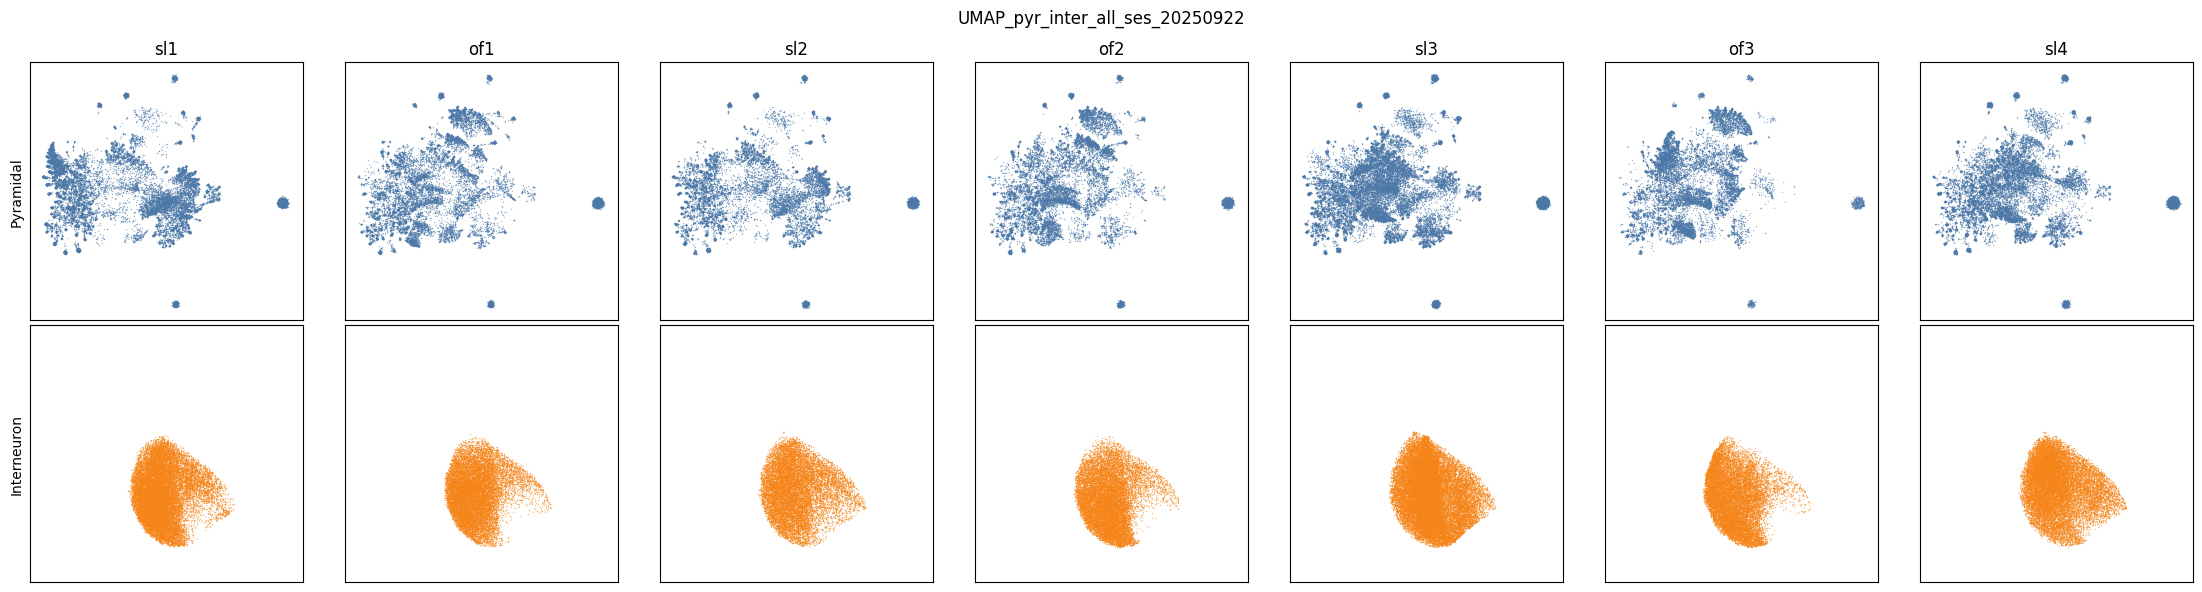

In [34]:
conds = ['sl1','of1','sl2','of2','sl3','of3','sl4']
pyr_dict = emb_pyr_dict
inter_dict = emb_inter_dict

# Global UMAP axis limits (shared across subplots)
def get_global_limits(dicts):
    xs, ys = [], []
    for D in dicts:
        for k in conds:
            if k in D:
                xs.append(D[k][:,0])
                ys.append(D[k][:,1])
    x_all = np.concatenate(xs)
    y_all = np.concatenate(ys)
    pad = 0.05
    return (
        x_all.min() - pad * np.ptp(x_all),
        x_all.max() + pad * np.ptp(x_all),
        y_all.min() - pad * np.ptp(y_all),
        y_all.max() + pad * np.ptp(y_all)
    )

xmin, xmax, ymin, ymax = get_global_limits([pyr_dict, inter_dict])

# Plot grid
fig, axes = plt.subplots(2, len(conds), figsize=(3.2 * len(conds), 6),
                         sharex=True, sharey=True)

style = dict(s=1, alpha=0.5, linewidths=0)

for j, cond in enumerate(conds):
    # Row 0: Pyr
    ax = axes[0, j]
    emb = pyr_dict.get(cond, None)
    if emb is not None:
        ax.scatter(emb[:,0], emb[:,1], c='#4C78A8', label='Pyr', **style)
    if j == 0:
        ax.set_ylabel('Pyramidal')
    ax.set_title(cond)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_aspect('equal')

    # Row 1: Inter
    ax = axes[1, j]
    emb = inter_dict.get(cond, None)
    if emb is not None:
        ax.scatter(emb[:,0], emb[:,1], c='#F58518', label='Inter', **style)
    if j == 0:
        ax.set_ylabel('Interneuron')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_aspect('equal')

filename = f'UMAP_pyr_inter_all_ses_{date}'


fig.suptitle(filename, y=0.98)
plt.tight_layout()
plt.savefig(pa_path / f"{filename}.png", dpi=300, bbox_inches='tight')
plt.show()

In [43]:
520*0.85

442.0